In [1]:
import copy
import datetime
import warnings
warnings.filterwarnings(action='ignore') 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 시각화
import seaborn as sns
# 결측치
import missingno as msno

import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import model_selection, linear_model
from sklearn.metrics import auc

# 파이프라인
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn import cluster

# 데이터 불러오기

In [2]:
data_df = pd.read_excel('2.all_data(전처리전_피쳐추출).xls')
data_df.head(3)

,고객번호,거주지,연령,가입경로,담당사원,상품코드,상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,사용포인트,포인트사용여부,잔여포인트,재구매여부
0,11454,대구광역시,1979-06-15 00:00:00,M,박애신,89003,72,24.0,20,664200,184200,480000,28.0,0.0,0,96,0
1,14506,경기도,1986-09-11 00:00:00,M,전우영,89003,24,NaN,56,1771200,331200,1440000,19.0,120000.0,1,130,0
2,83078,충청남도,1111-11-11,M,박애신,89003,684,1044.0,420,15055200,3055200,12000000,20.0,0.0,0,96,0


# 데이터 탐색

In [3]:
# 총 24280 데이터 중 결측치 확인
#지역, 연령, 담당직원, 재구매일, 총구매횟수, 할인율, 사용포인트, 잔여포인트 결측치 확인
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24801 entries, 0 to 24800
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   고객번호     24801 non-null  int64  
 1   거주지      24777 non-null  object 
 2   연령       22199 non-null  object 
 3   가입경로     24801 non-null  object 
 4   담당사원     24283 non-null  object 
 5   상품코드     24801 non-null  int64  
 6   상담횟수     24801 non-null  int64  
 7   총구매횟수    18155 non-null  float64
 8   총구매수량    24801 non-null  int64  
 9   총구매금액    24801 non-null  int64  
 10  총할인금액    24801 non-null  int64  
 11  최종결제금액   24801 non-null  int64  
 12  할인율      24799 non-null  float64
 13  사용포인트    24408 non-null  float64
 14  포인트사용여부  24801 non-null  int64  
 15  잔여포인트    24801 non-null  int64  
 16  재구매여부    24801 non-null  int64  
dtypes: float64(3), int64(10), object(4)
memory usage: 3.2+ MB


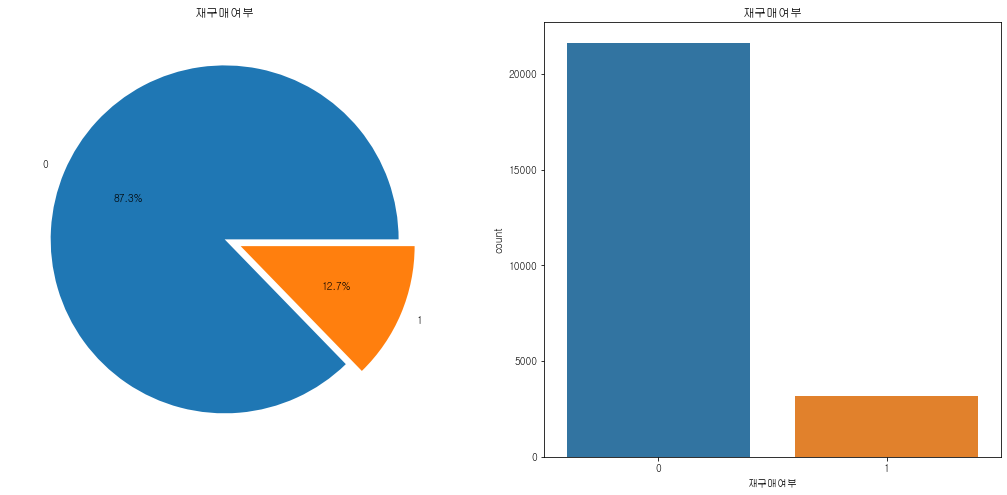

In [4]:
f, ax = plt.subplots(1,2,figsize=(18,8))
data_df['재구매여부'].value_counts()\
.plot.pie(explode = [0,0.1], autopct = '%1.1f%%', ax=ax[0])

ax[0].set_title('재구매여부')
ax[0].set_ylabel('')

sns.countplot('재구매여부', data = data_df, ax = ax[1])
ax[1].set_title('재구매여부')
plt.show()

In [5]:
# f, ax = plt.subplots(1,2,figsize=(18,8))
# msno.heatmap(data_df,ax=ax[0])
# ax[0].set_title('결측치 히트맵')

# msno.matrix(data_df,ax=ax[1])
# ax[1].set_title('결측치 매트릭스')

# 결측치 핸들링

## 고객번호, 사용포인트 삭제
- 필요없는정보이므로 삭제

In [6]:
del data_df['고객번호']
del data_df['사용포인트']

In [7]:
data_df.head()

,거주지,연령,가입경로,담당사원,상품코드,상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,포인트사용여부,잔여포인트,재구매여부
0,대구광역시,1979-06-15 00:00:00,M,박애신,89003,72,24.0,20,664200,184200,480000,28.0,0,96,0
1,경기도,1986-09-11 00:00:00,M,전우영,89003,24,NaN,56,1771200,331200,1440000,19.0,1,130,0
2,충청남도,1111-11-11,M,박애신,89003,684,1044.0,420,15055200,3055200,12000000,20.0,0,96,0
3,인천광역시,1983-03-06 00:00:00,E,전우영,89003,15,NaN,12,332100,152100,180000,46.0,0,130,0
4,경기도,1984-06-06 00:00:00,H,박애신,89002,10,NaN,8,221400,101400,120000,46.0,0,96,0


Text(0.5, 1.0, '결측치 매트릭스')

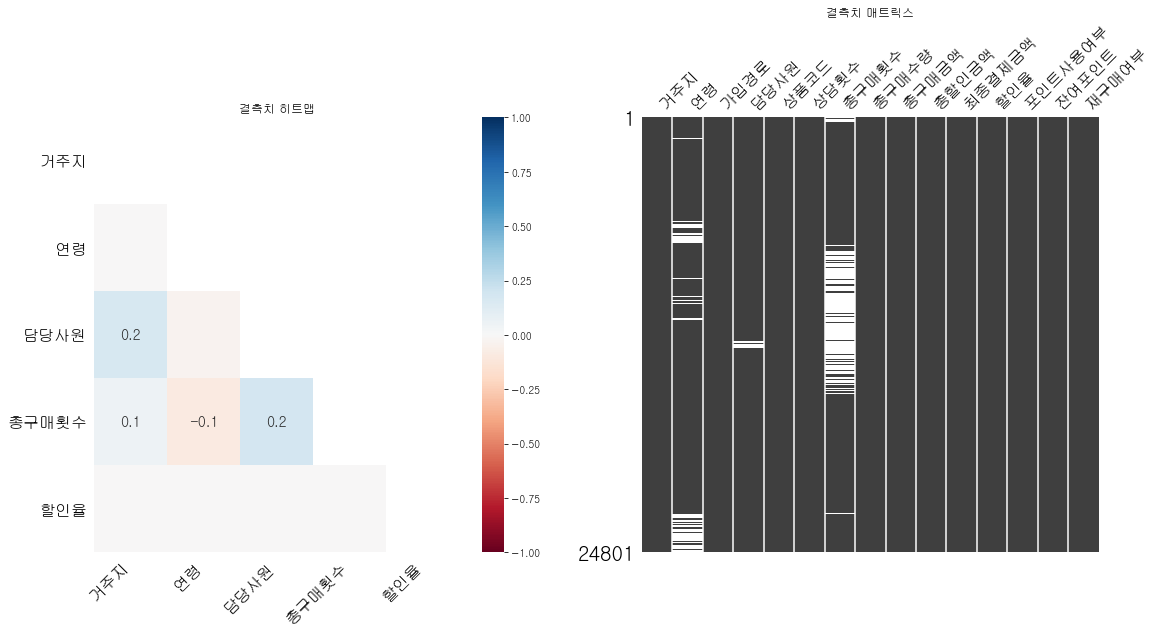

In [8]:
f, ax = plt.subplots(1,2,figsize=(18,8))
msno.heatmap(data_df,ax=ax[0])
ax[0].set_title('결측치 히트맵')

msno.matrix(data_df,ax=ax[1])
ax[1].set_title('결측치 매트릭스')

## 지역 열
- 전체데이터 24325 행중 24행에 해당 전체데이터의 약 0.2퍼센트 해당 삭제 처리

In [9]:
data_df["거주지"].value_counts()

경기도        6949
서울특별시      3108
경상남도       1672
인천광역시      1593
부산광역시      1554
경상북도       1466
대구광역시      1354
충청남도       1157
충청북도        848
전라북도        819
전라남도        812
대전광역시       796
광주광역시       771
울산광역시       683
강원도         637
제주특별자치도     301
세종특별자치시     228
없음           29
Name: 거주지, dtype: int64

In [10]:
data_df[data_df["거주지"] == "없음"].count()

거주지        29
연령         29
가입경로       29
담당사원        0
상품코드       29
상담횟수       29
총구매횟수       0
총구매수량      29
총구매금액      29
총할인금액      29
최종결제금액     29
할인율        29
포인트사용여부    29
잔여포인트      29
재구매여부      29
dtype: int64

In [11]:
data_df[data_df["거주지"].isnull()].count()

거주지         0
연령         23
가입경로       24
담당사원        5
상품코드       24
상담횟수       24
총구매횟수       0
총구매수량      24
총구매금액      24
총할인금액      24
최종결제금액     24
할인율        24
포인트사용여부    24
잔여포인트      24
재구매여부      24
dtype: int64

In [12]:
data_df_del_add = data_df[data_df["거주지"] != "없음"]

In [13]:
data_df_del_add = data_df_del_add[data_df_del_add["거주지"].notnull()]

In [14]:
data_df_del_add["거주지"].isnull().value_counts()

False    24748
Name: 거주지, dtype: int64

In [15]:
data_df_del_add[data_df_del_add["거주지"]=="없음"].count()

거주지        0
연령         0
가입경로       0
담당사원       0
상품코드       0
상담횟수       0
총구매횟수      0
총구매수량      0
총구매금액      0
총할인금액      0
최종결제금액     0
할인율        0
포인트사용여부    0
잔여포인트      0
재구매여부      0
dtype: int64

In [16]:
data_df_del_add.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24748 entries, 0 to 24800
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   거주지      24748 non-null  object 
 1   연령       22147 non-null  object 
 2   가입경로     24748 non-null  object 
 3   담당사원     24278 non-null  object 
 4   상품코드     24748 non-null  int64  
 5   상담횟수     24748 non-null  int64  
 6   총구매횟수    18155 non-null  float64
 7   총구매수량    24748 non-null  int64  
 8   총구매금액    24748 non-null  int64  
 9   총할인금액    24748 non-null  int64  
 10  최종결제금액   24748 non-null  int64  
 11  할인율      24746 non-null  float64
 12  포인트사용여부  24748 non-null  int64  
 13  잔여포인트    24748 non-null  int64  
 14  재구매여부    24748 non-null  int64  
dtypes: float64(2), int64(9), object(4)
memory usage: 3.0+ MB


In [17]:
data_df_temp = data_df_del_add.copy()

## 연령 열
- 현재 생년월일로 표현된 컬럼의 밸류를 년도로 바꾸고, k-means 알고리즘을 적용하여 군집화 확인 후 평균값 적용

### 나이/생일 열의 평균치 구하기

In [18]:
data_df_temp['연령'].isnull().value_counts()

False    22147
True      2601
Name: 연령, dtype: int64

In [19]:
#나이/생일 열의 평균치를 구하기 위하여 결측,이상치를 제거한 임시 데이터 프래임을 생성한다.
data_df_birth = data_df_temp[data_df_temp["연령"].notnull()]
data_df_birth = data_df_birth[data_df_temp["연령"]!=0]
data_df_birth = data_df_birth[data_df_temp["연령"]!="0000-00-00"]
data_df_birth = data_df_birth[data_df_temp["연령"]!="1111-11-11"]
data_df_birth = data_df_birth[data_df_temp["연령"]!="1700-01-01"]

In [20]:
data_df_birth = data_df_birth.reset_index()
del data_df_birth["index"]
data_df_birth

,거주지,연령,가입경로,담당사원,상품코드,상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,포인트사용여부,잔여포인트,재구매여부
0,대구광역시,1979-06-15 00:00:00,M,박애신,89003,72,24.0,20,664200,184200,480000,28.0,0,96,0
1,경기도,1986-09-11 00:00:00,M,전우영,89003,24,NaN,56,1771200,331200,1440000,19.0,1,130,0
2,인천광역시,1983-03-06 00:00:00,E,전우영,89003,15,NaN,12,332100,152100,180000,46.0,0,130,0
3,경기도,1984-06-06 00:00:00,H,박애신,89002,10,NaN,8,221400,101400,120000,46.0,0,96,0
4,충청북도,1988-06-14 00:00:00,H,전우영,89001,32,NaN,92,2878200,598200,2280000,21.0,0,130,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21805,경기도,2022-08-30 00:00:00,A,NaN,35023,1,0.0,0,18900,16400,2500,87.0,0,160,0
21806,경상남도,2022-08-31 00:00:00,H,박애신,35025,1,1.0,1,18900,15900,3000,84.0,0,96,0
21807,서울특별시,2022-08-31 00:00:00,H,박애신,35008,1,1.0,1,18900,13900,5000,74.0,0,96,0
21808,전라남도,2022-08-31 00:00:00,H,박애신,35025,1,1.0,1,18900,15900,3000,84.0,0,96,0


In [21]:
data_df_birth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21810 entries, 0 to 21809
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   거주지      21810 non-null  object 
 1   연령       21810 non-null  object 
 2   가입경로     21810 non-null  object 
 3   담당사원     21515 non-null  object 
 4   상품코드     21810 non-null  int64  
 5   상담횟수     21810 non-null  int64  
 6   총구매횟수    15922 non-null  float64
 7   총구매수량    21810 non-null  int64  
 8   총구매금액    21810 non-null  int64  
 9   총할인금액    21810 non-null  int64  
 10  최종결제금액   21810 non-null  int64  
 11  할인율      21808 non-null  float64
 12  포인트사용여부  21810 non-null  int64  
 13  잔여포인트    21810 non-null  int64  
 14  재구매여부    21810 non-null  int64  
dtypes: float64(2), int64(9), object(4)
memory usage: 2.5+ MB


In [22]:
# datetime 형태로 변환
data_df_birth['연령'] = pd.to_datetime(data_df_birth['연령'])
data_df_birth.head()

,거주지,연령,가입경로,담당사원,상품코드,상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,포인트사용여부,잔여포인트,재구매여부
0,대구광역시,1979-06-15,M,박애신,89003,72,24.0,20,664200,184200,480000,28.0,0,96,0
1,경기도,1986-09-11,M,전우영,89003,24,NaN,56,1771200,331200,1440000,19.0,1,130,0
2,인천광역시,1983-03-06,E,전우영,89003,15,NaN,12,332100,152100,180000,46.0,0,130,0
3,경기도,1984-06-06,H,박애신,89002,10,NaN,8,221400,101400,120000,46.0,0,96,0
4,충청북도,1988-06-14,H,전우영,89001,32,NaN,92,2878200,598200,2280000,21.0,0,130,0


In [23]:
data_df_birth['연령_연도'] = data_df_birth['연령'].dt.year

In [24]:
# 평균값을 내기 위해 너프하게 미성년자에 해당하는 이상치 제거
data_df_birth_del = data_df_birth[data_df_birth['연령'].dt.year > 2002].index
data_df_birth_del

Int64Index([    7,     8,    13,    14,    16,    17,    18,    19,    20,
               21,
            ...
            21800, 21801, 21802, 21803, 21804, 21805, 21806, 21807, 21808,
            21809],
           dtype='int64', length=14803)

In [25]:
data_df_birth.drop(data_df_birth_del, axis='index', inplace=True)
data_df_birth.head()

,거주지,연령,가입경로,담당사원,상품코드,상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,포인트사용여부,잔여포인트,재구매여부,연령_연도
0,대구광역시,1979-06-15,M,박애신,89003,72,24.0,20,664200,184200,480000,28.0,0,96,0,1979
1,경기도,1986-09-11,M,전우영,89003,24,NaN,56,1771200,331200,1440000,19.0,1,130,0,1986
2,인천광역시,1983-03-06,E,전우영,89003,15,NaN,12,332100,152100,180000,46.0,0,130,0,1983
3,경기도,1984-06-06,H,박애신,89002,10,NaN,8,221400,101400,120000,46.0,0,96,0,1984
4,충청북도,1988-06-14,H,전우영,89001,32,NaN,92,2878200,598200,2280000,21.0,0,130,0,1988


In [26]:
# a = data_df_birth[data_df_birth['재구매여부'] == 1]
# a['연령_연도'].value_counts().plot(kind='bar')

In [27]:
data_df_birth = data_df_birth.reset_index()

In [28]:
# 간단하게 기술통계학으로 확인한 평균값 1987년도
data_df_birth[['연령_연도']].describe()

,연령_연도
count,7007.000000
mean,1987.749393
std,4.829138
min,1900.000000
25%,1985.000000
50%,1988.000000
75%,1991.000000
max,2002.000000


### k-means 적용 (나이)

In [29]:
data_df_birth_con = data_df_birth[['연령_연도']]

In [30]:
kmeans = cluster.KMeans(n_clusters=5, random_state=0).fit(data_df_birth_con) 

In [31]:
# 군집 중심 확인 및 컬럼이름 붙히기
pd.DataFrame(kmeans.cluster_centers_, columns=data_df_birth_con.columns, index=range(5))

,연령_연도
0,1981.946276
1,1995.071287
2,1986.579313
3,1990.356198
4,1957.294118


In [32]:
# 입력한 배열에 동일한 값의 개수가 몇개있는지 알수있다
print(np.unique(kmeans.labels_, return_counts=True))

(array([0, 1, 2, 3, 4]), array([1638, 1010, 2301, 2041,   17], dtype=int64))


163383.9349222208
68749.96948223317
42387.32689537861
30832.296354948583
21288.488432881502
15550.217577638685
12439.677293144168
8678.086973904738
6833.363679174616
5358.994421633892
4355.867236475572
3577.614635986873
3192.4240947929848
2790.4784924523833


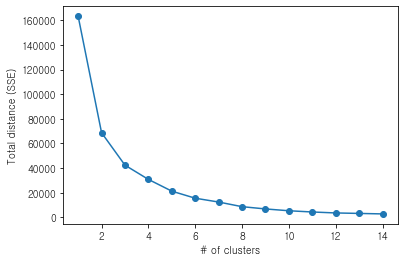

In [33]:
def elbow(data_df_birth_con):
    total_distance = []
    for i in range(1, 15):
        model = cluster.KMeans(n_clusters=i, random_state=0)
        model.fit(data_df_birth_con)
        
        # inertia : Sum of squared distances of samples to their closest cluster center.
        total_distance.append(model.inertia_) 
        print(model.inertia_)
        
    plt.plot(range(1, 15), total_distance, marker='o')
    plt.xlabel('# of clusters')
    plt.ylabel('Total distance (SSE)')
    plt.show()

elbow(data_df_birth_con) # Iris case : 2

## 원본데이터 연령 열 결측치에 평균값 처리
- k-means로 확인한 결과 1986년도생에 군집이 몰려있음을 확인

In [34]:
data_df_temp['연령'].isnull().value_counts()

False    22147
True      2601
Name: 연령, dtype: int64

In [35]:
print(sum(data_df_temp['연령']== '0000-00-00'))
print(sum(data_df_temp['연령']== '1111-11-11'))
print(sum(data_df_temp['연령']== '1700-01-01'))
print(sum(data_df_temp['연령']== 0))
print(sum(data_df_temp['연령'].isnull()))

300
28
1
8
2601


In [36]:
data_df_temp['연령'].replace({'0000-00-00':'1986-01-01 00:00:00',\
                             '1111-11-11':'1986-01-01 00:00:00',\
                             '1700-01-01':'1986-01-01 00:00:00',\
                             0 : '1986-01-01'}, inplace=True)

In [37]:
data_df_temp['연령'].fillna('1986-01-01', inplace=True)

In [38]:
print(sum(data_df_temp['연령']== '0000-00-00'))
print(sum(data_df_temp['연령']== '1111-11-11'))
print(sum(data_df_temp['연령']== '1700-01-01'))
print(sum(data_df_temp['연령']== 0))
print(sum(data_df_temp['연령'].isnull()))

0
0
0
0
0


In [39]:
data_df_temp['연령'].isnull().value_counts()

False    24748
Name: 연령, dtype: int64

## 연령 열 이상치 처리
- 프로그램오류로 원본데이터의 미성년자 비율이 높음
- 전체데이터의 50%이상을 차지하여 삭제하는것보다 k-means 로 도출해낸 평균값 대입으로 이상치를 처리하였다.

In [40]:
# datetime 형태로 변환 후 미성년자 수 카운트 확인
data_df_temp['연령'] = pd.to_datetime(data_df_temp['연령'])
# data_df[data_df['나이/생일'].dt.year > 2003].count()

In [41]:
# 프로그램오류로 미성년자 비율이 높음.. 전체데이터의 50%이상을 차지하여 삭제하는것보다
# k-means 로 도출해낸 평균값 대입으로 이상치 처리
data_df_temp['연령'][data_df_temp['연령'].dt.year >= 2003] = '1986'

In [42]:
data_df_temp['연령_연도'] = data_df_temp['연령'].dt.year

In [43]:
del data_df_temp["연령"]

In [44]:
def age_cate(x):
    # 한국 나이 20대는 2003~1994
    if (x <= 2003) & (x >= 1994) :
        return 0
    elif (x <= 1993) & (x >= 1984) :
        return 1
    elif (x <= 1983) & (x >= 1974) :
        return 2
    elif (x <= 1973) & (x >= 1964) :
        return 3
    elif (x <= 1963) & (x >= 1954) :
        return 4
    elif (x <= 1953) & (x >= 1944) :
        return 5
    elif (x <= 1943) & (x >= 1934) :
        return 6
    else:
        return 7

data_df_temp['부모연령'] = data_df_temp['연령_연도'].apply(age_cate)

In [45]:
data_df_temp.head()

,거주지,가입경로,담당사원,상품코드,상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,포인트사용여부,잔여포인트,재구매여부,연령_연도,부모연령
0,대구광역시,M,박애신,89003,72,24.0,20,664200,184200,480000,28.0,0,96,0,1979,2
1,경기도,M,전우영,89003,24,NaN,56,1771200,331200,1440000,19.0,1,130,0,1986,1
2,충청남도,M,박애신,89003,684,1044.0,420,15055200,3055200,12000000,20.0,0,96,0,1986,1
3,인천광역시,E,전우영,89003,15,NaN,12,332100,152100,180000,46.0,0,130,0,1983,2
4,경기도,H,박애신,89002,10,NaN,8,221400,101400,120000,46.0,0,96,0,1984,1


In [46]:
del data_df_temp['연령_연도']
data_df_temp

,거주지,가입경로,담당사원,상품코드,상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,포인트사용여부,잔여포인트,재구매여부,부모연령
0,대구광역시,M,박애신,89003,72,24.0,20,664200,184200,480000,28.0,0,96,0,2
1,경기도,M,전우영,89003,24,NaN,56,1771200,331200,1440000,19.0,1,130,0,1
2,충청남도,M,박애신,89003,684,1044.0,420,15055200,3055200,12000000,20.0,0,96,0,1
3,인천광역시,E,전우영,89003,15,NaN,12,332100,152100,180000,46.0,0,130,0,2
4,경기도,H,박애신,89002,10,NaN,8,221400,101400,120000,46.0,0,96,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24796,경상남도,H,이선영,35009,1,1.0,1,36900,27000,9900,73.0,0,161,0,1
24797,부산광역시,H,박애신,35008,4,2.0,7,240300,103300,137000,43.0,0,96,0,1
24798,경상북도,H,전우영,35023,1,1.0,1,14000,11000,3000,79.0,0,130,0,1
24799,경기도,E,전우영,35009,1,1.0,1,36900,27000,9900,73.0,0,130,0,1


In [47]:
data_df_temp['부모연령'].value_counts()

1    22825
2     1199
0      698
3       14
4       10
6        1
7        1
Name: 부모연령, dtype: int64

In [48]:
data_df_add_age = data_df_temp.copy()

## 담당직원 열 결측치 처리
- 전체 데이터의 512행에 해당하는 데이터 null값 확인 약 2.4퍼센트행에 대한 K-means 알고리즘 적용

In [49]:
data_df_add_age["담당사원"].value_counts()

박애신      6225
전우영      5881
김필남      5128
정유경      3500
이선영      2294
마케팅1팀    1085
김영애        51
김연화        45
한나경        35
윤슬기        33
최고관리자       1
Name: 담당사원, dtype: int64

In [50]:
# 최고관리자 삭제
data_df_add_age = data_df_add_age[data_df_add_age["담당사원"] != "최고관리자"]

In [51]:
data_df_add_age["담당사원"].isnull().value_counts()

False    24277
True       470
Name: 담당사원, dtype: int64

In [52]:
# 담당직원열만 가져온다
df_employee = data_df_add_age[['담당사원']]

In [53]:
# 범주형 데이터이기때문에 dummies를 이용하여 숫자로 변환 (문자열은 k-means알고리즘 적용이 되지않음)
df_employee_temp = pd.get_dummies(df_employee, drop_first=True)
df_employee_temp.head()

,담당사원_김영애,담당사원_김필남,담당사원_마케팅1팀,담당사원_박애신,담당사원_윤슬기,담당사원_이선영,담당사원_전우영,담당사원_정유경,담당사원_한나경
0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0


In [54]:
from sklearn import cluster

In [55]:
kmeans = cluster.KMeans(n_clusters=6, random_state=0).fit(df_employee_temp) 

In [56]:
# 군집 중심 확인 및 컬럼이름 붙히기
pd.DataFrame(kmeans.cluster_centers_, columns=df_employee_temp.columns, index=range(6))

,담당사원_김영애,담당사원_김필남,담당사원_마케팅1팀,담당사원_박애신,담당사원_윤슬기,담당사원_이선영,담당사원_전우영,담당사원_정유경,담당사원_한나경
0,-9.974660e-18,5.273559e-16,-1.457168e-16,1.665335e-16,6.722053e-18,1.000000e+00,4.718448e-16,5.828671e-16,6.505213e-19
1,-3.035766e-18,1.360023e-15,-4.718448e-16,1.000000e+00,1.734723e-18,5.967449e-16,-1.110223e-16,-1.942890e-16,-9.324139e-18
2,-1.257675e-17,1.332268e-15,-4.579670e-16,0.000000e+00,4.119968e-18,4.718448e-16,1.000000e+00,3.885781e-16,-7.372575e-18
3,-1.170938e-17,7.216450e-16,-2.428613e-16,1.665335e-16,9.757820e-18,-4.302114e-16,5.551115e-16,1.000000e+00,2.602085e-18
4,-1.431147e-17,1.000000e+00,-4.163336e-16,1.665335e-16,8.239937e-18,1.387779e-16,6.661338e-16,7.771561e-16,-3.035766e-18
5,2.966841e-02,6.383782e-16,6.311809e-01,1.665335e-16,1.919721e-02,-6.938894e-17,3.608225e-16,3.885781e-16,2.036067e-02


In [57]:
# 군집 라벨 확인
print("Clusters : ", kmeans.labels_)

Clusters :  [1 2 1 ... 2 2 4]


In [58]:
# 입력한 배열에 동일한 값의 개수가 몇개있는지 알수있다
# 제일높은값은 6061개의 0번 군집 -> 박애신으로 확인
print(np.unique(kmeans.labels_, return_counts=True))

(array([0, 1, 2, 3, 4, 5]), array([2294, 6225, 5881, 3500, 5128, 1719], dtype=int64))


In [59]:
df_employee_temp['target'] = kmeans.labels_

In [60]:
df_employee_temp

,담당사원_김영애,담당사원_김필남,담당사원_마케팅1팀,담당사원_박애신,담당사원_윤슬기,담당사원_이선영,담당사원_전우영,담당사원_정유경,담당사원_한나경,target
0,0,0,0,1,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,2
2,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,2
4,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
24796,0,0,0,0,0,1,0,0,0,0
24797,0,0,0,1,0,0,0,0,0,1
24798,0,0,0,0,0,0,1,0,0,2
24799,0,0,0,0,0,0,1,0,0,2


<AxesSubplot:>

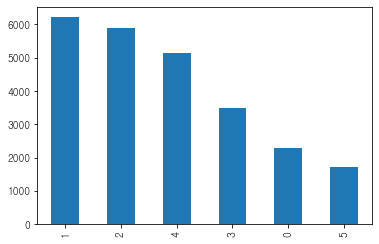

In [61]:
df_employee_temp['target'].value_counts().plot(kind = "bar") # plotting a "bar" graph

In [62]:
# plt.scatter(df_employee_temp['TM담당직원_박애신'], df_employee_temp['target'], c='green')
# plt.show()

### 최적 클러스터 개수 찾기
- 엘보우 기법 사용

71683.27094193293
27128.032771999515
15217.528113130553
8635.020917735612
3606.2088505914944
516.3094822571263
111.24763406940059
64.03087478559176
31.012773722627728
1.9517683471723288e-24
2.02542902806604e-24
1.932667215801892e-24
1.9112911558684368e-24
1.941241307971428e-24


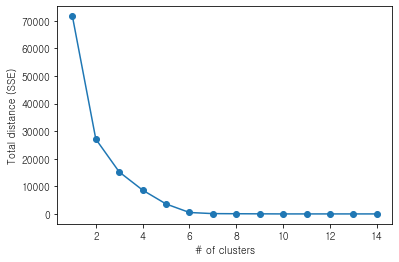

In [63]:
def elbow(df_employee_temp):
    total_distance = []
    for i in range(1, 15):
        model = cluster.KMeans(n_clusters=i, random_state=0)
        model.fit(df_employee_temp)
        
        # inertia : Sum of squared distances of samples to their closest cluster center.
        total_distance.append(model.inertia_) 
        print(model.inertia_)
        
    plt.plot(range(1, 15), total_distance, marker='o')
    plt.xlabel('# of clusters')
    plt.ylabel('Total distance (SSE)')
    plt.show()

elbow(df_employee_temp) # Iris case : 2

## TM 담당사원 결측치 적용
- k-means 알고리즘으로 제일 군집도가 높은 값이 박애신사원으로 확인됨
- 원본데이터 결측치에 박애신사원 적용

In [64]:
data_df_add_age["담당사원"].fillna("박애신", inplace=True)

In [65]:
data_df_add_age["담당사원"].isnull().value_counts()

False    24747
Name: 담당사원, dtype: int64

In [66]:
data_df_add_age_tm = data_df_add_age.copy()

## 총구매 횟수 열 결측치 평균값으로 대체
- 전체 데이터의 6480행에 해당하는 데이터 null값 확인 약 26퍼센트행에 대한 K-means 알고리즘 적용

In [67]:
data_df_add_age_tm["총구매횟수"].isnull().value_counts()

False    18155
True      6592
Name: 총구매횟수, dtype: int64

In [68]:
# 총구매횟수열만 가져온다
df_count = data_df_add_age_tm[data_df_add_age_tm['총구매횟수'].notnull()]
df_count_temp = df_count[['총구매횟수']]

In [69]:
kmeans = cluster.KMeans(n_clusters=6, random_state=0).fit(df_count_temp) 

In [70]:
# 군집 중심 확인 및 컬럼이름 붙히기
pd.DataFrame(kmeans.cluster_centers_, columns=df_count_temp.columns, index=range(6))

,총구매횟수
0,4.810176
1,1432.846154
2,243.003571
3,3450.666667
4,76.788799
5,563.692308


In [71]:
# 입력한 배열에 동일한 값의 개수가 몇개있는지 알수있다
print(np.unique(kmeans.labels_, return_counts=True))

(array([0, 1, 2, 3, 4, 5]), array([16273,    26,   280,     3,  1482,    91], dtype=int64))


146994463.0955648
68219694.46869016
35158928.68061902
23738548.930277657
13994207.552231012
10429097.961181924
6990476.83173109
5206933.046311702
4213991.221152526
3437536.3746891995
2670801.3512043566
2095889.1602428937
1741631.9734360115
1499025.9507418121


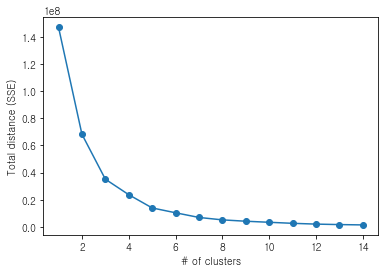

In [72]:
# 최적의 클러스터 갯수 확인 : 엘보우포인트
def elbow(df_count_temp):
    total_distance = []
    for i in range(1, 15):
        model = cluster.KMeans(n_clusters=i, random_state=0)
        model.fit(df_count_temp)
        
        # inertia : Sum of squared distances of samples to their closest cluster center.
        total_distance.append(model.inertia_) 
        print(model.inertia_)
        
    plt.plot(range(1, 15), total_distance, marker='o')
    plt.xlabel('# of clusters')
    plt.ylabel('Total distance (SSE)')
    plt.show()

elbow(df_count_temp) # Iris case : 2

## 총구매횟수 결측치 처리
- k-means로 확인한 군집도 높은값은 5.5
- 원본데이터 총구매횟수 결측치에 5.5로 처리

In [73]:
data_df_add_age_tm['총구매횟수'].fillna(5.5,inplace=True)

In [74]:
data_df_add_age_tm['총구매횟수'].isnull().value_counts()

False    24747
Name: 총구매횟수, dtype: int64

In [75]:
data_df_add_age_tm_count = data_df_add_age_tm.copy()

## 할인율 결측치처리

In [76]:
data_df_add_age_tm_count['할인율'].value_counts()

 84.0     5063
 100.0    4010
 74.0     3148
 79.0     1390
 86.0      644
          ... 
 68.0        1
-12.0        1
 398.0       1
 299.0       1
-2.0         1
Name: 할인율, Length: 101, dtype: int64

In [77]:
data_df_add_age_tm_count['할인율'].isnull().value_counts()

False    24745
True         2
Name: 할인율, dtype: int64

## 할인율 열 결측치 삭제
- 마이너스나 100을 넘는 이상치들은 35건정도로 1% 미만이므로 삭제한다

In [78]:
data_df_add_age_tm_count['할인율'].value_counts()

 84.0     5063
 100.0    4010
 74.0     3148
 79.0     1390
 86.0      644
          ... 
 68.0        1
-12.0        1
 398.0       1
 299.0       1
-2.0         1
Name: 할인율, Length: 101, dtype: int64

In [79]:
# 마이너스나 100을 넘는 이상치들은 35건정도로 1% 미만이므로 삭제한다
data_df_add_age_tm_count = data_df_add_age_tm_count[data_df_add_age_tm_count['할인율']<=101]
data_df_add_age_tm_count = data_df_add_age_tm_count[data_df_add_age_tm_count['할인율']>0]
data_df_add_age_tm_count = data_df_add_age_tm_count[data_df_add_age_tm_count['할인율'].notnull()]

data_df_add_age_tm_count.head()

,거주지,가입경로,담당사원,상품코드,상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,포인트사용여부,잔여포인트,재구매여부,부모연령
0,대구광역시,M,박애신,89003,72,24.0,20,664200,184200,480000,28.0,0,96,0,2
1,경기도,M,전우영,89003,24,5.5,56,1771200,331200,1440000,19.0,1,130,0,1
2,충청남도,M,박애신,89003,684,1044.0,420,15055200,3055200,12000000,20.0,0,96,0,1
3,인천광역시,E,전우영,89003,15,5.5,12,332100,152100,180000,46.0,0,130,0,2
4,경기도,H,박애신,89002,10,5.5,8,221400,101400,120000,46.0,0,96,0,1


In [80]:
data_df_add_age_tm_count['할인율'].value_counts()

84.0     5063
100.0    4010
74.0     3148
79.0     1390
86.0      644
         ... 
65.0        2
68.0        1
95.0        1
67.0        1
3.0         1
Name: 할인율, Length: 92, dtype: int64

In [81]:
data_df_add_age_tm_count.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24701 entries, 0 to 24800
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   거주지      24701 non-null  object 
 1   가입경로     24701 non-null  object 
 2   담당사원     24701 non-null  object 
 3   상품코드     24701 non-null  int64  
 4   상담횟수     24701 non-null  int64  
 5   총구매횟수    24701 non-null  float64
 6   총구매수량    24701 non-null  int64  
 7   총구매금액    24701 non-null  int64  
 8   총할인금액    24701 non-null  int64  
 9   최종결제금액   24701 non-null  int64  
 10  할인율      24701 non-null  float64
 11  포인트사용여부  24701 non-null  int64  
 12  잔여포인트    24701 non-null  int64  
 13  재구매여부    24701 non-null  int64  
 14  부모연령     24701 non-null  int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 3.0+ MB


In [82]:
data_df_add_age_tm_count_per = data_df_add_age_tm_count.copy()

Text(0.5, 1.0, '결측치 매트릭스')

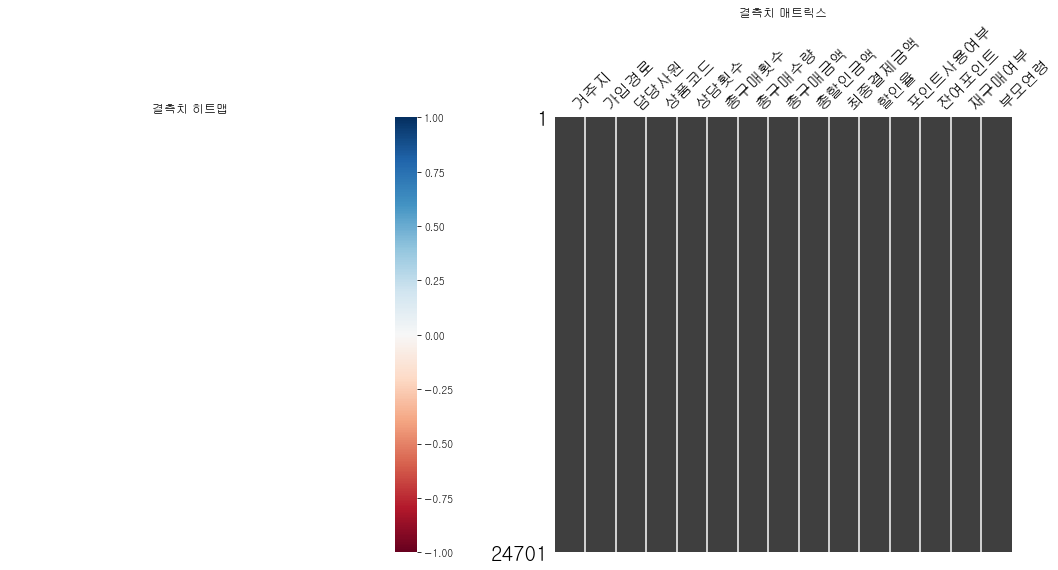

In [113]:
f, ax = plt.subplots(1,2,figsize=(18,8))
msno.heatmap(data_df_add_age_tm_count_per,ax=ax[0])
ax[0].set_title('결측치 히트맵')

msno.matrix(data_df_add_age_tm_count_per,ax=ax[1])
ax[1].set_title('결측치 매트릭스')

# 이상치 핸들링

## IQR 계산 후 처리

In [87]:
# 연속형 변수
# 자녀의 수가 0인경우가 너무 많음 부정확함 제외
# 사용포인트도 안사용한경우가 더 많음.. 포인트 사용 여부로 범주형으로 돌려야함

# num_data = data_df_add_age_tm_count_per_point[['총상담횟수','총구매횟수', '총구매수량',\
#                                                '총구매금액','총할인금액','최종결제금액',\
#                                                '할인율','사용포인트','잔여포인트','자녀수']]

num_data = data_df_add_age_tm_count_per[['상담횟수','총구매횟수', '총구매수량',\
                                               '총구매금액','총할인금액','최종결제금액',\
                                               '할인율','잔여포인트']]
num_data.astype('float')
num_data

,상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,잔여포인트
0,72,24.0,20,664200,184200,480000,28.0,96
1,24,5.5,56,1771200,331200,1440000,19.0,130
2,684,1044.0,420,15055200,3055200,12000000,20.0,96
3,15,5.5,12,332100,152100,180000,46.0,130
4,10,5.5,8,221400,101400,120000,46.0,96
...,...,...,...,...,...,...,...,...
24796,1,1.0,1,36900,27000,9900,73.0,161
24797,4,2.0,7,240300,103300,137000,43.0,96
24798,1,1.0,1,14000,11000,3000,79.0,130
24799,1,1.0,1,36900,27000,9900,73.0,130


In [88]:
# 각 연속형 컬럼마다 IQR값 계산
import numpy as np
def IQR_rule(val_list): # 한 특징에 포함된 값 (열 벡터)
    # IQR 계산    
    Q1 = np.quantile(val_list, 0.25)
    Q3 = np.quantile(val_list, 0.75)
    IQR = Q3 - Q1
    
    # IQR rule을 위배하지 않는 bool list 계산 (True: 이상치 X, False: 이상치 O)
    not_outlier_condition = (Q3 + 1.5 * IQR > val_list) & (Q1 - 1.5 * IQR < val_list)
    return not_outlier_condition

In [89]:
conditions = num_data.apply(IQR_rule) # apply를 이용하여 모든 컬럼에 IQR rule 함수 적용
conditions

,상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,잔여포인트
0,False,False,True,True,True,True,True,True
1,True,True,False,False,False,False,True,True
2,False,False,False,False,False,False,True,True
3,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...
24796,True,True,True,True,True,True,True,True
24797,True,True,True,True,True,True,True,True
24798,True,True,True,True,True,True,True,True
24799,True,True,True,True,True,True,True,True


In [90]:
total_condition = conditions.sum(axis = 1) == len(num_data.columns) # 하나라도 IQR 규칙을 위반하는 요소를 갖는 레코드를 제거하기 위한 규칙
num_data = num_data.loc[total_condition] # 이상치 제거

In [92]:
# 원본데이터 24701행 중 5006행의 이상치가 제거되어 19695행이 되었음
# 이상치는 20%정도

num_row = num_data.shape[0]
defalt_row = data_df_add_age_tm.shape[0]

print(defalt_row-num_row)
print((defalt_row-num_row)/defalt_row)

5006
0.20228714591667676


# 원본데이터에 이상치 제거한 데이터 적용

In [93]:
num_data
#num_data.loc[[19826]]

,상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,잔여포인트
3,15,5.5,12,332100,152100,180000,46.0,130
4,10,5.5,8,221400,101400,120000,46.0,96
6,4,2.0,12,42000,42000,0,100.0,96
9,0,5.5,8,221400,101400,120000,46.0,71
16,6,5.5,14,442800,202800,240000,46.0,160
...,...,...,...,...,...,...,...,...
24796,1,1.0,1,36900,27000,9900,73.0,161
24797,4,2.0,7,240300,103300,137000,43.0,96
24798,1,1.0,1,14000,11000,3000,79.0,130
24799,1,1.0,1,36900,27000,9900,73.0,130


In [95]:
# left_index=True, right_index=True 옵션을 넣으면 
# 왼쪽 데이터프레임의 인덱스와 오른쪽 데이터프레임의 인덱스가 같은 행만 추출한다. (inner 기본 적용)
data_df_add_age_tm_out = pd.merge(data_df_add_age_tm_count_per, num_data, left_index=True, right_index=True)

In [96]:
data_df_add_age_tm_out.head()

,거주지,가입경로,담당사원,상품코드,상담횟수_x,총구매횟수_x,총구매수량_x,총구매금액_x,총할인금액_x,최종결제금액_x,...,재구매여부,부모연령,상담횟수_y,총구매횟수_y,총구매수량_y,총구매금액_y,총할인금액_y,최종결제금액_y,할인율_y,잔여포인트_y
3,인천광역시,E,전우영,89003,15,5.5,12,332100,152100,180000,...,0,2,15,5.5,12,332100,152100,180000,46.0,130
4,경기도,H,박애신,89002,10,5.5,8,221400,101400,120000,...,0,1,10,5.5,8,221400,101400,120000,46.0,96
6,경기도,H,박애신,35086,4,2.0,12,42000,42000,0,...,0,2,4,2.0,12,42000,42000,0,100.0,96
9,경상남도,E,김필남,89001,0,5.5,8,221400,101400,120000,...,0,1,0,5.5,8,221400,101400,120000,46.0,71
16,경기도,E,정유경,89003,6,5.5,14,442800,202800,240000,...,0,1,6,5.5,14,442800,202800,240000,46.0,160


In [99]:
data_df_add_age_tm_out_join = data_df_add_age_tm_out[['거주지','가입경로','담당사원','상품코드',\
                                                     '상담횟수_y','총구매횟수_y',\
                                                     '총구매수량_y','총구매금액_y',\
                                                     '총할인금액_y','최종결제금액_y',\
                                                     '할인율_y','잔여포인트_y',\
                                                     '재구매여부','부모연령','포인트사용여부']]
data_df_add_age_tm_out_join

,거주지,가입경로,담당사원,상품코드,상담횟수_y,총구매횟수_y,총구매수량_y,총구매금액_y,총할인금액_y,최종결제금액_y,할인율_y,잔여포인트_y,재구매여부,부모연령,포인트사용여부
3,인천광역시,E,전우영,89003,15,5.5,12,332100,152100,180000,46.0,130,0,2,0
4,경기도,H,박애신,89002,10,5.5,8,221400,101400,120000,46.0,96,0,1,0
6,경기도,H,박애신,35086,4,2.0,12,42000,42000,0,100.0,96,0,2,0
9,경상남도,E,김필남,89001,0,5.5,8,221400,101400,120000,46.0,71,0,1,0
16,경기도,E,정유경,89003,6,5.5,14,442800,202800,240000,46.0,160,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24796,경상남도,H,이선영,35009,1,1.0,1,36900,27000,9900,73.0,161,0,1,0
24797,부산광역시,H,박애신,35008,4,2.0,7,240300,103300,137000,43.0,96,0,1,0
24798,경상북도,H,전우영,35023,1,1.0,1,14000,11000,3000,79.0,130,0,1,0
24799,경기도,E,전우영,35009,1,1.0,1,36900,27000,9900,73.0,130,0,1,0


In [100]:
data_df_add_age_tm_out_join.shape

(19741, 15)

# 값이 작은 이상치 제거(범주형)

In [101]:
#범주형 컬럼 vaule_counts
print(data_df_add_age_tm_out_join["거주지"].value_counts())
print("===================================")
print(data_df_add_age_tm_out_join["가입경로"].value_counts())
print("===================================")
print(data_df_add_age_tm_out_join["담당사원"].value_counts())
print("===================================")
print(data_df_add_age_tm_out_join["상품코드"].value_counts())
print("===================================")
print(data_df_add_age_tm_out_join["부모연령"].value_counts())
print("===================================")

경기도        5514
서울특별시      2575
경상남도       1327
부산광역시      1287
인천광역시      1255
경상북도       1162
대구광역시      1089
충청남도        904
대전광역시       655
충청북도        652
전라북도        636
광주광역시       618
전라남도        604
울산광역시       557
강원도         499
제주특별자치도     220
세종특별자치시     187
Name: 거주지, dtype: int64
H     8917
E     3270
F     2736
O     2297
Y      713
A      276
P      250
R      224
V      220
I      139
Q      106
M       86
N       68
D       58
T       57
B       56
U       51
K       47
G       42
C       35
L       29
W       19
AA      18
J       10
X        8
DD       6
CC       3
Name: 가입경로, dtype: int64
박애신      5301
전우영      4553
김필남      4083
정유경      2782
이선영      1823
마케팅1팀    1055
김영애        51
김연화        45
윤슬기        33
한나경        15
Name: 담당사원, dtype: int64
35007    6773
35026    2375
35023    2032
35008    1736
35024    1008
         ... 
38002       1
18001       1
52007       1
90007       1
78011       1
Name: 상품코드, Length: 69, dtype: int64
1    18172
2      962
0   

In [102]:
data_df_final = data_df_add_age_tm_out_join[data_df_add_age_tm_out_join["가입경로"]!="AA"]
data_df_final = data_df_final[data_df_add_age_tm_out_join["가입경로"]!="J"]
data_df_final = data_df_final[data_df_add_age_tm_out_join["가입경로"]!="X"]
data_df_final = data_df_final[data_df_add_age_tm_out_join["가입경로"]!="DD"]
data_df_final = data_df_final[data_df_add_age_tm_out_join["가입경로"]!="CC"]

# data_df_final = data_df_add_age_tm_out_join[data_df_add_age_tm_out_join["체험상품"]!="90001"]
# data_df_final = data_df_add_age_tm_out_join[data_df_add_age_tm_out_join["가입경로"]!="CC"]

data_df_final

,거주지,가입경로,담당사원,상품코드,상담횟수_y,총구매횟수_y,총구매수량_y,총구매금액_y,총할인금액_y,최종결제금액_y,할인율_y,잔여포인트_y,재구매여부,부모연령,포인트사용여부
3,인천광역시,E,전우영,89003,15,5.5,12,332100,152100,180000,46.0,130,0,2,0
4,경기도,H,박애신,89002,10,5.5,8,221400,101400,120000,46.0,96,0,1,0
6,경기도,H,박애신,35086,4,2.0,12,42000,42000,0,100.0,96,0,2,0
9,경상남도,E,김필남,89001,0,5.5,8,221400,101400,120000,46.0,71,0,1,0
16,경기도,E,정유경,89003,6,5.5,14,442800,202800,240000,46.0,160,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24796,경상남도,H,이선영,35009,1,1.0,1,36900,27000,9900,73.0,161,0,1,0
24797,부산광역시,H,박애신,35008,4,2.0,7,240300,103300,137000,43.0,96,0,1,0
24798,경상북도,H,전우영,35023,1,1.0,1,14000,11000,3000,79.0,130,0,1,0
24799,경기도,E,전우영,35009,1,1.0,1,36900,27000,9900,73.0,130,0,1,0


In [106]:
data_df_final['상품코드'].value_counts()

35007    6765
35026    2360
35023    2024
35008    1736
35024    1008
35009     864
35025     856
35033     667
35032     630
35031     539
36002     166
35034     158
71011     154
35005     152
35035     127
35086     125
71012     112
35006     111
36001      89
90010      84
90009      78
89003      70
36003      68
71003      67
71001      62
35029      61
37003      61
71013      55
36004      44
35011      41
71002      38
90008      35
35022      31
35027      29
72011      25
27001      23
35028      21
89002      17
Name: 상품코드, dtype: int64

In [105]:
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=35001]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=38004]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=90002]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=83001]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=90012]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=90007]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=90004]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=35030]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=73001]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=72010]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=39002]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=38003]

data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=90013]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=90006]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=90005]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=90011]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=73002]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=38001]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=38002]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=72001]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=90001]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=72012]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=37001]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=90014]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=72002]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=35021]

data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=89001]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=12009]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=52001]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=18001]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=48001]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=52007]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=78011]
data_df_final = data_df_final[data_df_add_age_tm_out_join["상품코드"]!=12001]

data_df_final

,거주지,가입경로,담당사원,상품코드,상담횟수_y,총구매횟수_y,총구매수량_y,총구매금액_y,총할인금액_y,최종결제금액_y,할인율_y,잔여포인트_y,재구매여부,부모연령,포인트사용여부
3,인천광역시,E,전우영,89003,15,5.5,12,332100,152100,180000,46.0,130,0,2,0
4,경기도,H,박애신,89002,10,5.5,8,221400,101400,120000,46.0,96,0,1,0
6,경기도,H,박애신,35086,4,2.0,12,42000,42000,0,100.0,96,0,2,0
16,경기도,E,정유경,89003,6,5.5,14,442800,202800,240000,46.0,160,0,1,0
21,세종특별자치시,H,박애신,89002,16,10.0,8,221400,101400,120000,46.0,96,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24796,경상남도,H,이선영,35009,1,1.0,1,36900,27000,9900,73.0,161,0,1,0
24797,부산광역시,H,박애신,35008,4,2.0,7,240300,103300,137000,43.0,96,0,1,0
24798,경상북도,H,전우영,35023,1,1.0,1,14000,11000,3000,79.0,130,0,1,0
24799,경기도,E,전우영,35009,1,1.0,1,36900,27000,9900,73.0,130,0,1,0


In [107]:
# 연령 3,4,7

data_df_final = data_df_final[data_df_add_age_tm_out_join["부모연령"]!=3]
data_df_final = data_df_final[data_df_add_age_tm_out_join["부모연령"]!=4]
data_df_final = data_df_final[data_df_add_age_tm_out_join["부모연령"]!=7]

In [108]:
print(data_df_final['가입경로'].value_counts())

print(data_df_final['상품코드'].value_counts())

print(data_df_final['부모연령'].value_counts())


H    8867
E    3217
F    2731
O    2293
Y     712
A     271
P     250
R     224
V     202
I     137
Q     105
M      85
N      68
D      58
B      56
T      52
U      47
K      47
G      42
C      35
W      19
L      17
Name: 가입경로, dtype: int64
35007    6762
35026    2360
35023    2017
35008    1734
35024    1008
35009     864
35025     854
35033     666
35032     630
35031     538
36002     166
35034     158
71011     154
35005     152
35035     127
35086     124
71012     112
35006     111
36001      89
90010      84
90009      78
89003      70
36003      68
71003      67
35029      61
71001      61
37003      61
71013      55
36004      44
35011      41
71002      38
90008      35
35022      31
35027      29
72011      25
27001      23
35028      21
89002      17
Name: 상품코드, dtype: int64
1    17989
2      959
0      587
Name: 부모연령, dtype: int64


In [109]:
data_df_final.count()

거주지         19535
가입경로        19535
담당사원        19535
상품코드        19535
상담횟수_y      19535
총구매횟수_y     19535
총구매수량_y     19535
총구매금액_y     19535
총할인금액_y     19535
최종결제금액_y    19535
할인율_y       19535
잔여포인트_y     19535
재구매여부       19535
부모연령        19535
포인트사용여부     19535
dtype: int64

In [110]:
# reset index 해주자
data_df_final.reset_index(inplace=True)

In [111]:
#data_df_final.to_excel('milk_preprocessing_outlier.xlsx')